# Probability formulas

Let's explore the formulas used in the project and also visualize the impact of even tiny bias over a number can have over the played tickets. This part is not necessary to understand the TensorFlow 2.0 part, feel free to skip to next section.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import itertools
from collections import defaultdict
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})

# Base distribution: which numbers are preferred

Our goal is to find the players bias towards each number using only the lottery results and the number of players that won. To understand how the two are connected, we can start from a given base distribution, showing how likely players are to choose a given number from 1 to 49 and another independent distribution of how inclined they feel between 1 and 10 (called the "lucky" number). Our final question is then: how likelly are players to choose the given winner numbers?

Let's build the formula step-by-step. If you're impatient, you can skip to the last section of this page.

In this file, we'll consider a fake preference distribution. Since we're talking about probability and all possible options are known, we must have:

$$ \sum_{i} B_i = 1 $$

In the graphs below, the dashed black represent what an uniform, that is unbiased, distribution would look like.

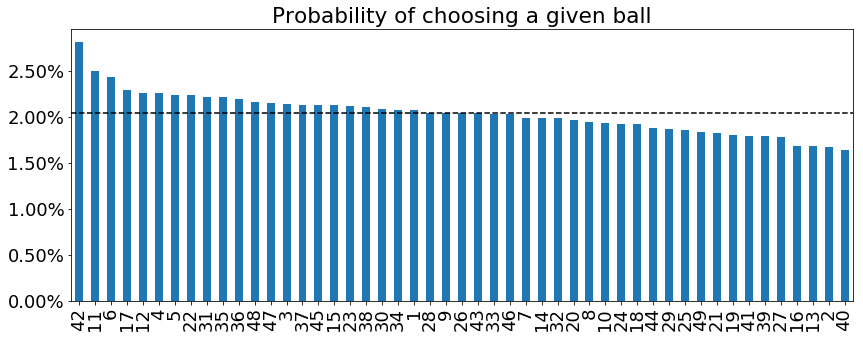

Most common is 1.7x more likelly than least common


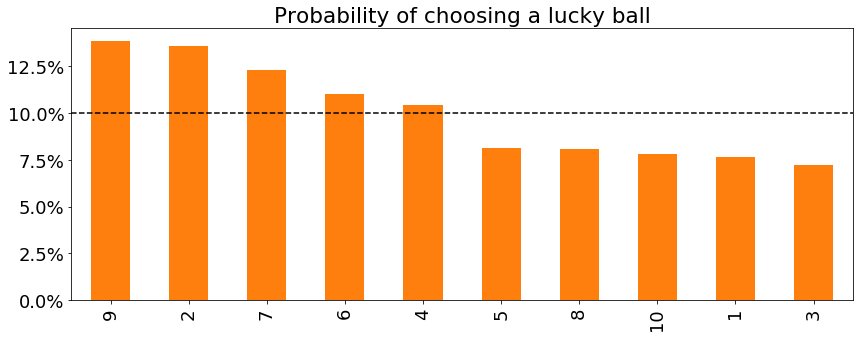

Most common is 1.9x more likelly than least common


In [2]:
np.random.seed(17)
probs1 = np.exp(np.random.normal(0, 0.1, 49))
probs1 = pd.Series(probs1 / np.sum(probs1), index=range(1, 50))
probs2 = np.exp(np.random.normal(0, 0.3, 10))
probs2 = pd.Series(probs2 / np.sum(probs2), index=range(1, 11))

probs1.sort_values(ascending=False).plot.bar(figsize=(14, 5), color='C0', width=0.5)
plt.axhline(1 / 49, color='black', linestyle='--')
plt.gca().get_yaxis().set_major_formatter(PercentFormatter(1))
plt.title('Probability of choosing a given ball')
plt.show()
print('Most common is {:.1f}x more likelly than least common'.format(probs1.max() / probs1.min()))

probs2.sort_values(ascending=False).plot.bar(figsize=(14, 5), color='C1', width=0.5)
plt.axhline(1 / 10, color='black', linestyle='--')
plt.gca().get_yaxis().set_major_formatter(PercentFormatter(1))
plt.title('Probability of choosing a lucky ball')
plt.show()
print('Most common is {:.1f}x more likelly than least common'.format(probs2.max() / probs2.min()))

## Taking pairs

What is the likelihood of players choosing a given pair of numbers, say 12 and 17? Let's ignore the second set of numbers for the moment.

Rather surprisingly, it's **not** $ b_{12} * b_{17} $! And why not? Because:

1. after choosing 12 as their first number, the second (17) will be drawn from the remaining **48** numbers. It means, its likelihood is now $ b_{17} / (1 - b_{12}) $, since 12 is no longer in the pool. You can convince yourself if you take the extreme case of a lottery with only two numbers from which players have to pick two. Do you see how the second number will certainly be picked?

2. besides, a player can either pick 12 and then 17 or do it in the reverse order, the two cases should be added

That revised expression is:

$$ P(a, b) = a \frac{b}{1 - a} + b \frac{a}{1 - b} $$

The graph below ilustrate the most and least likely pairs from our example distribution. Note how the 1.7 times preference over a single number grows into 2.6x for pairs. This tendancy will be accentuaded as we grow the size of the set of chosen numbers.

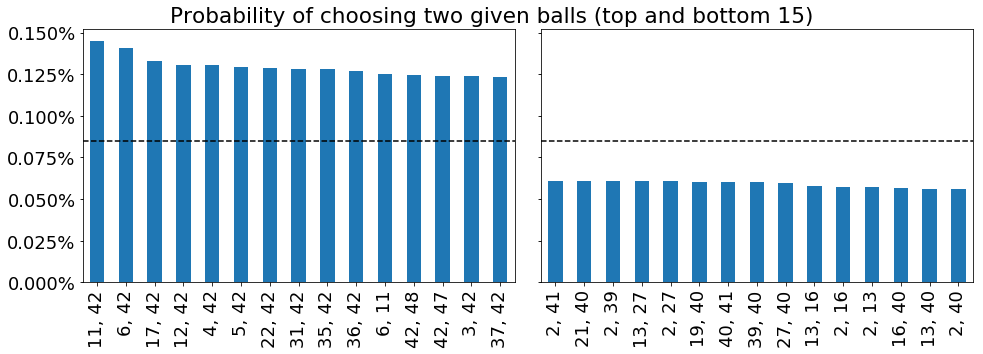

Most common is 2.6x more likelly than least common


In [3]:
def exact_comb_prob(probs):
    prob = 0
    for perm in itertools.permutations(probs):
        term = perm[0]
        remainder = 1 - term
        for p in perm[1:]:
            term *= p / remainder
            remainder -= p
        prob += term
    return prob

def exact_comb_distro(probs, n_balls):
    distro = {}
    for comb in itertools.combinations(sorted(probs.index), n_balls):
        distro[', '.join(map(str, comb))] = exact_comb_prob(probs.loc[list(comb)])
    return pd.Series(distro)

def plot_comb_distro(distro, n_top=15):
    plt.figure(figsize=(14, 5))
    plt.subplot(121)
    distro = distro.sort_values(ascending=False)
    distro.head(n_top).plot.bar()
    plt.axhline(1 / len(distro), color='black', linestyle='--')
    plt.gca().get_yaxis().set_major_formatter(PercentFormatter(1))
    
    plt.subplot(122, sharey=plt.gca())
    distro.tail(n_top).plot.bar()
    plt.axhline(1 / len(distro), color='black', linestyle='--')
    plt.tight_layout()

probs1_2 = exact_comb_distro(probs1, 2)
plot_comb_distro(probs1_2)
plt.suptitle('Probability of choosing two given balls (top and bottom 15)', y=1)
plt.show()
print('Most common is {:.1f}x more likelly than least common'.format(probs1_2.max() / probs1_2.min()))

# Take it to the three

The reasoning is mostly the same when compared to taking pairs, however there are 6 ways of taking three numbers, so our formula will have 6 terms. Look how the denominator decreases within each term.

$$ P(a, b, c) = a \frac{b}{1 - a} \frac{c}{1 - a - b} +
a \frac{c}{1 - a} \frac{b}{1 - a - c} +
b \frac{a}{1 - b} \frac{c}{1 - b - a} + \\
b \frac{c}{1 - b} \frac{a}{1 - b - c} +
c \frac{a}{1 - c} \frac{b}{1 - c - a} +
c \frac{b}{1 - c} \frac{a}{1 - c - b} $$

You can already where we're reading to for our full 5-numbers set. There are 120 permutations of 5 numbers, so our final equation will have 120 adding terms, which one composed of 5 multipling terms.

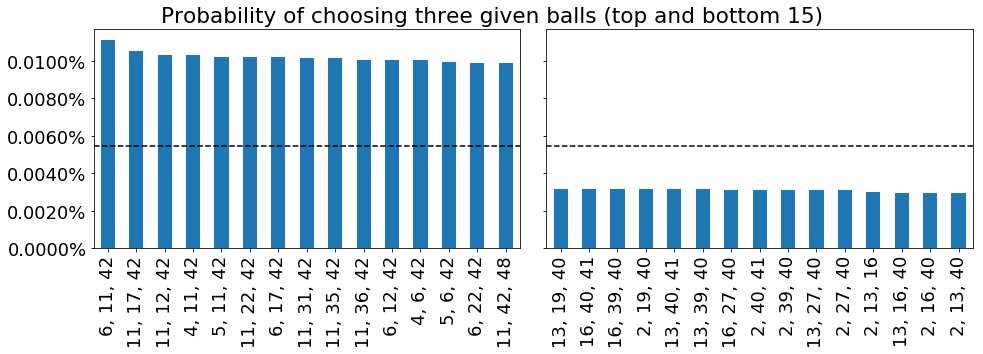

Most common is 3.8x more likelly than least common


In [4]:
probs1_3 = exact_comb_distro(probs1, 3)
plot_comb_distro(probs1_3)
plt.suptitle('Probability of choosing three given balls (top and bottom 15)', y=1)
plt.show()
print('Most common is {:.1f}x more likelly than least common'.format(probs1_3.max() / probs1_3.min()))

# Simplifying a bit

Unfortunately, the exact equation above will have too many terms for our case of 5-numbers sets (we're still ignoring the lucky number). 120 terms may seen doable and we'll should test it, however we should remember the optimized will derivate this gigantic expression for each of the 49 variables (the base probabilities we're looking for).

In fact, the main concern is not computation time. Our dataset is rather small and we could compensate it with different techniques. My concern is numerical stability! With a formula with *many* adding and multipling similar terms, the errors in the float operations can add up and sometimes just give straight up unacceptable results. I don't understand enough about the issue in fact, it's more of a fear.

The idea is to cut corners and simplify our equation. We'd be losing precision for performance and stability. Deal!

The bad thing about our formula is that each factor is different, making it hard to squeeze all them together. What if we replaced the denominator with something more predictable, like the average of the arguments?

From the 3-numbers set above, see how all denominators will be factored out (here $\rho$ is the average of a, b, c):

$$ P(a, b, c) = \frac{6 a b c}{(1 - \rho) (1 - 2 \rho)} $$

It's a lot simpler in fact. So much so, we can now write our full 5-number-set formula:

$$ P(a, b, c, d, e) = \frac{120 a b c d e}{(1 - \rho) (1 - 2 \rho) (1 - 3 \rho) (1 - 4 \rho)} $$

Below an example of the difference between the exact and this simplified formula. It's precise to the 4th significant digit:

In [5]:
def simple_prob(probs, numbers):
    term = 1
    remaing_prob = 1
    avg = probs[numbers].mean()
    for number in numbers:
        term *= probs[number] / remaing_prob
        remaing_prob -= avg
    return math.factorial(len(numbers)) * term

top_3_bottom_2 = [42, 11, 6, 2, 40]
exact = exact_comb_prob(probs1[top_3_bottom_2])
simple = simple_prob(probs1, top_3_bottom_2)
print('{:.9%}'.format(exact))
print('{:.9%}'.format(simple))

0.000071151%
0.000071136%


# I'm feeling lucky

We've been ignoring the lucky number up to this point. Fortunately, it's straightforward: since selecting the lucky number $l$ from 1 to 10 is an independent process from the other 5 numbers, we just have to multiply the previous formula by its likelihood. We'll call it $P_1$ for reasons that will be evident in the next section:

$$ P_1(a, b, c, d, e, l) = \frac{120 a b c d e l}{(1 - \rho) (1 - 2 \rho) (1 - 3 \rho) (1 - 4 \rho)} $$

# The winner does not take it all

We've focused only in the jackpot: getting all 5 and the lucky number correct. But players can also smaller prizes with smaller points: the French loterry has nine prize levels in total as of today. However, up until 2017 they had only six. Therefore, we'll use those six prize levels so that we can use historical data from 2008 until today:

1. (Jackpot) 5 numbers + lucky
2. 5 numbers and no lucky
3. exactly 4 numbers
4. exactly 3 numbers
5. exactly 2 numbers
6. exactly 1 number + lucky or no number + lucky

Notice how these six levels are mutually exclusive, that is, a player can win at most at one of them.

The probability of the second level can be derived from $P_1$. See, our player has to get all 5 numbers and NOT the lucky one:

$$ P_2(a, b, c, d, e, l) = \frac{120 a b c d e (1 - l)}{(1 - \rho) (1 - 2 \rho) (1 - 3 \rho) (1 - 4 \rho)} $$

The third level will require more effort. See, all 49 numbers are divided into two groups: the 5 "good" numbers and 44 "bad" ones. Our player has to choose exactly 4 good and 1 bad (the lucky number doesn't matter). There are 5 way of selecting 4 out of 5:

$$ P_3(a, b, c, d, e) = Q_3(a, b, c, d) + Q_3(a, b, c, e) + Q_3(a, b, d, e) + Q_3(a, c, d, e) + Q_3(b, c, d, e) $$

However there are 44 ways of selecting the bad number. Here, we'll apply a similar logic as before to simplify things a bit: we'll assume all bad numbers have the same likelihood. This is really important, since for the other levels, the number of combinations explodes! At level 6, there will be 1,086,008 ways of doing so!

$$ Q_3(a, b, c, d) = 44 \frac{120 a b c d \tau}{(1 - \rho) (1 - 2 \rho) (1 - 3 \rho) (1 - 4 \rho)} $$

Where $\tau$ is the average over the bad numbers and $\rho = (a+b+c+d+\tau)/5$. Notice how that's a bit counter intuitive: the aim of this project is to to find how choices are biased and now we've just assumed there are not!

Numerically, though, the difference is very small, on the 4th significant digit on the example below:

In [6]:
def exact_p3(good_probs, bad_probs):
    prob = 0
    for gp in itertools.combinations(good_probs, 4):
        for bp in bad_probs:
            prob += exact_comb_prob([*gp, bp])
    return prob

def simple_p3(good_probs, bad_probs):
    prob = 0
    tau = np.mean(bad_probs)
    for gp in itertools.combinations(good_probs, 4):
        rho = np.mean([*gp, tau])
        prob += 44 * 120 * np.product(gp) * tau / ((1 - rho) * (1 - 2*rho) * (1 - 3*rho) * (1 - 4*rho))
    return prob

good_numbers = [3, 14, 15, 35, 32]
good_probs = probs1[good_numbers]
bad_probs = probs1[np.setdiff1d(probs1.index, good_numbers)]
print('{:.9%}'.format(exact_p3(good_probs, bad_probs)))
print('{:.9%}'.format(simple_p3(good_probs, bad_probs)))

0.012745845%
0.012738320%


# I'm feeling (not so) lucky

We can proceed identically for level 4, now with 10 ways to choose 3 good numbers:

$$ P_4(a, b, c, d, e) = Q_4(a, b, c) + Q_4(a, b, d) + Q_4(a, b, e) + Q_4(a, c, d) + Q_4(a, c, e) + Q_4(a, d, e) + Q_4(b, c, d) + Q_4(b, c, e) + Q_4(b, d, e) + Q_4(c, d, e) $$

Each of which with 946 ways to select 2 bad numbers, using the nice simplification above and $\rho = (a+b+c+2\tau)/5$:

$$ Q_4(a, b, c) = 946 \frac{120 a b c \tau^2}{(1 - \rho) (1 - 2 \rho) (1 - 3 \rho) (1 - 4 \rho)} $$

One more time, with 10 ways to pick 2 good numbers:

$$ P_5(a, b, c, d, e) = Q_5(a, b) + Q_5(a, c) + Q_5(a, d) + Q_5(a, e) + Q_5(b, c) + Q_5(b, d) + Q_5(b, e) + Q_5(c, d) + Q_5(c, e) + Q_5(d, e) $$

And 13244 ways of picking 3 bad ones:

$$ Q_5(a, b) = 13244 \frac{120 a b \tau^3}{(1 - \rho) (1 - 2 \rho) (1 - 3 \rho) (1 - 4 \rho)} $$

The sixth and final level will break out of this routine a bit with the reappearance of the lucky number:

$$ P_6(a, b, c, d, e, l) = Q_6(a, l) + Q_6(b, l) + Q_6(c, l) + Q_6(d, l) + Q_6(e, l) + R_6(l) $$

With $Q_6$ choosing 4 bad numbers and the poor $R_6$ getting all 5 wrong!

$$ Q_6(a, l) = 135751 \frac{120 a l \tau^4}{(1 - \rho) (1 - 2 \rho) (1 - 3 \rho) (1 - 4 \rho)} $$
$$ R_6(l) = 1086008 \frac{120 l \tau^5}{(1 - \rho) (1 - 2 \rho) (1 - 3 \rho) (1 - 4 \rho)} $$